# Sequential vs Pipeline Fusion and Hardware Optimization

Evaluating the benefits of pipeline fusion over sequential using an architecture and workloads inspired by the Tangram paper.

In [ ]:
# Pipeline

## Channel sweep for convolution workload

We start by testing our sequential and pipeline mappings on the convolution workload to see how the energy and latency vary as the number of channels increases, which corresponds to an increase in the complexity of the problem.

In [113]:
### with CONV files but for changing the channels, sequential
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml
import matplotlib.pyplot as plt

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

workload_file = None

# --- Load YAML ---
with open('../configs/conv_workload.yaml', 'r') as file:
    workload_file = yaml.load(file, Loader=yaml.FullLoader)


# get the parts of dictionary that define whether we are doing pipelined
# and tile_shape of each rank



# print(workload_file["problem"])

final_string = "channels, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"


# workload_file["problem"][
x_array_channels = []
y_latency_array_sequential = []
y_energy_array_sequential = []
y_dram_energy_array_sequential = []
    
for i in range(3, 8):
    x_array_channels.append(2**i)
    layer_one_input_channels = 2**i
    layer_two_input_channels = 2**i
    layer_two_output_channels = 2**i
    
    instance_string_one = f"0 <= N < 128 and 0 <= M < {layer_two_input_channels} and 0 <= P < 128 and 0 <= Q < 128 and 0 <= C < {layer_one_input_channels} and 0 <= R < 128 and 0 <= S < 128"
    
    instance_string_two = f"0 <= N2 < 128 and 0 <= M2 < {layer_two_output_channels} and 0 <= P2 < 128 and 0 <= Q2 < 128 and 0 <= C2 < {layer_two_input_channels} and 0 <= R2 < 128 and 0 <= S2 < 128"
    
    for key in workload_file["problem"]:
        name = key['shape']['name']
        # print(key)
        if name == 'Conv1':
            key['instance'] = instance_string_one
        else:
            key['instance'] = instance_string_two

    with open('../configs/conv_workload.yaml', 'w') as file:
        yaml.dump(workload_file, file, default_flow_style=False)

    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping_sequential.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{2**i},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{en[('output_reg', 'read')]},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    y_latency_array_sequential.append(stats.latency)
    total_energy = sum(en[key] for key in en)
    y_energy_array_sequential.append(total_energy)
    y_dram_energy_array_sequential.append(en[('MainMemory', 'read')] + en[('MainMemory', 'write')])

import csv

In [114]:
### with CONV files but for changing the channels, pipeline
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml
import matplotlib.pyplot as plt

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

workload_file = None

# --- Load YAML ---
with open('../configs/conv_workload.yaml', 'r') as file:
    workload_file = yaml.load(file, Loader=yaml.FullLoader)


# get the parts of dictionary that define whether we are doing pipelined
# and tile_shape of each rank

final_string = "channels, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"
x_array_channels = []
y_latency_array_pipeline = []
y_energy_array_pipeline = []
y_dram_energy_array_pipeline = []

# workload_file["problem"][

for i in range(3, 8):
    x_array_channels.append(2**i)
    layer_one_input_channels = 2**i
    layer_two_input_channels = 2**i
    layer_two_output_channels = 2**i
    
    instance_string_one = f"0 <= N < 128 and 0 <= M < {layer_two_input_channels} and 0 <= P < 128 and 0 <= Q < 128 and 0 <= C < {layer_one_input_channels} and 0 <= R < 128 and 0 <= S < 128"
    
    instance_string_two = f"0 <= N2 < 128 and 0 <= M2 < {layer_two_output_channels} and 0 <= P2 < 128 and 0 <= Q2 < 128 and 0 <= C2 < {layer_two_input_channels} and 0 <= R2 < 128 and 0 <= S2 < 128"
    
    for key in workload_file["problem"]:
        name = key['shape']['name']
        # print(key)
        if name == 'Conv1':
            key['instance'] = instance_string_one
        else:
            key['instance'] = instance_string_two

    with open('../configs/conv_workload.yaml', 'w') as file:
        yaml.dump(workload_file, file, default_flow_style=False)

    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{2**i},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{en[('output_reg', 'read')]},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    y_latency_array_pipeline.append(stats.latency)
    total_energy = sum(en[key] for key in en)
    y_energy_array_pipeline.append(total_energy)
    y_dram_energy_array_pipeline.append(en[('MainMemory', 'read')] + en[('MainMemory', 'write')])

import csv

# Comparing latency after sweeping channels

The graphs generated below demonstrate how the latency changes with sequential and pipeline mappings for the same level of complexity

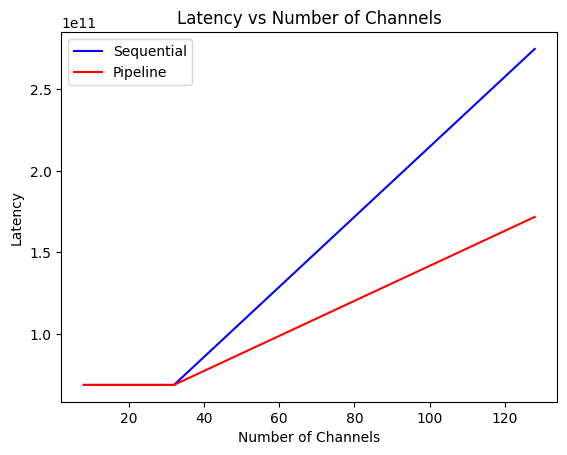

In [116]:
fig, ax1 = plt.subplots()

#for latency
# Plot the first y array
ax1.plot(x_array_channels, y_latency_array_sequential, 'b-', label='Sequential')
ax1.plot(x_array_channels, y_latency_array_pipeline, 'r-', label='Pipeline')

ax1.set_xlabel('Number of Channels')
ax1.set_ylabel('Latency')
ax1.set_title('Latency vs Number of Channels')

# Show legend and grid
ax1.legend()
# ax1.grid(True)

# Show the plot
plt.show()

# Show the plot
plt.show()


# Comparing Total and DRAM Energy after sweeping channels

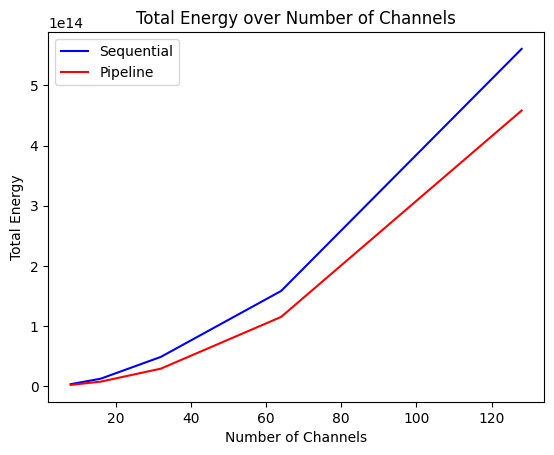

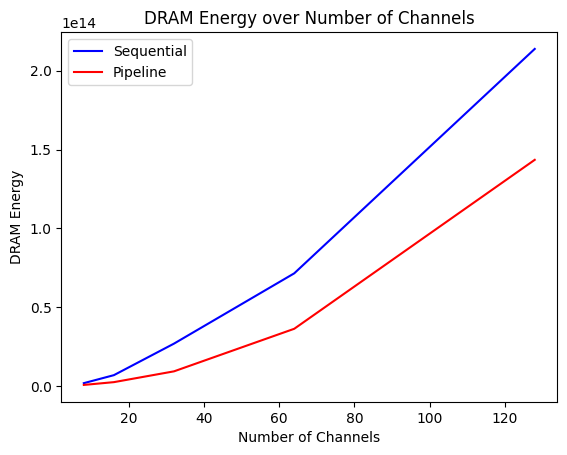

In [119]:
fig, total_energy_plot = plt.subplots()

#for total energy
# Plot the first y array
total_energy_plot.plot(x_array_channels, y_energy_array_sequential, 'b-', label='Sequential')
total_energy_plot.plot(x_array_channels, y_energy_array_pipeline, 'r-', label='Pipeline')

total_energy_plot.set_xlabel('Number of Channels')
total_energy_plot.set_ylabel('Total Energy')
total_energy_plot.set_title('Total Energy over Number of Channels')

# Show legend and grid
total_energy_plot.legend()
# ax1.grid(True)

# Show the plot
plt.show()

# Show the plot
plt.show()

# for DRAM energy
fig, dram_energy_plot = plt.subplots()

#for total energy
# Plot the first y array
dram_energy_plot.plot(x_array_channels, y_dram_energy_array_sequential, 'b-', label='Sequential')
dram_energy_plot.plot(x_array_channels, y_dram_energy_array_pipeline, 'r-', label='Pipeline')

dram_energy_plot.set_xlabel('Number of Channels')
dram_energy_plot.set_ylabel('DRAM Energy')
dram_energy_plot.set_title('DRAM Energy over Number of Channels')

# Show legend and grid
dram_energy_plot.legend()
# ax1.grid(True)

# Show the plot
plt.show()

# Show the plot
plt.show()


## Sweeping over height and width dimensions for matrix multiplications

In [149]:
### with new matrix files but for changing the height and width, sequential
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

workload_file = None

# --- Load YAML ---
with open('../configs/new_matrix_workload.yaml', 'r') as file:
    workload_file = yaml.load(file, Loader=yaml.FullLoader)


# get the parts of dictionary that define whether we are doing pipelined
# and tile_shape of each rank



# print(workload_file["problem"])

final_string = "channels, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"


# workload_file["problem"][

x_array_dimensions = []
y_energy_array_sequential = []
y_latency_array_sequential = []

for i in range(64, 128, 4):
    x_array_dimensions.append(i)
    # print(i)
   
    
    instance_string_one = f"0 <= N < 1 and 0 <= M < 1 and 0 <= P <= {i} and 0 <= Q <= {i} and 0 <= C < 1 and 0 <= R <= 1 and 0 <= S < 1"
    
    instance_string_two = f"0 <= N2 < 1 and 0 <= M2 < 1 and 0 <= P2 <= {i} and 0 <= Q2 <= {i} and 0 <= C2 < 1 and 0 <= R2 <= 1 and 0 <= S2 < 1"
    
    for key in workload_file["problem"]:
        name = key['shape']['name']
        # print(key)
        if name == 'Conv1':
            key['instance'] = instance_string_one
        else:
            key['instance'] = instance_string_two

    with open('../configs/new_matrix_workload.yaml', 'w') as file:
        yaml.dump(workload_file, file, default_flow_style=False)

    # print(workload_file)
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'new_matrix_workload.yaml','new_matrix_mapping_sequential.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{2**i},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{0},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    #en[('output_reg', 'read')]
    total_energy = sum(en[key] for key in en)
    y_energy_array_sequential.append(total_energy)
    y_latency_array_sequential.append(stats.latency)
    #
# plt.plot(x_array_dimensions, y_energy_array_sequential)
# plt.xlabel("Height/Width")
# plt.ylabel("Total Energy")
# plt.title("Total Energy over Dimensions")
# plt.show()

# plt.plot(x_array_dimensions, y_latency_array_sequential)
# plt.xlabel("Height/Width")
# plt.ylabel("Latency")
# plt.title("Latency over Dimensions")
# plt.show()

In [150]:
### with new matrix files but for changing the height and width, pipeline
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

workload_file = None

# --- Load YAML ---
with open('../configs/new_matrix_workload.yaml', 'r') as file:
    workload_file = yaml.load(file, Loader=yaml.FullLoader)


# get the parts of dictionary that define whether we are doing pipelined
# and tile_shape of each rank



# print(workload_file["problem"])

final_string = "channels, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"


# workload_file["problem"][

x_array_dimensions = []
y_energy_array_pipeline = []
y_latency_array_pipeline = []

for i in range(64, 128, 4):
    x_array_dimensions.append(i)
    # print(i)
   
    
    instance_string_one = f"0 <= N < 1 and 0 <= M < 1 and 0 <= P <= {i} and 0 <= Q <= {i} and 0 <= C < 1 and 0 <= R <= 1 and 0 <= S < 1"
    
    instance_string_two = f"0 <= N2 < 1 and 0 <= M2 < 1 and 0 <= P2 <= {i} and 0 <= Q2 <= {i} and 0 <= C2 < 1 and 0 <= R2 <= 1 and 0 <= S2 < 1"
    
    for key in workload_file["problem"]:
        name = key['shape']['name']
        # print(key)
        if name == 'Conv1':
            key['instance'] = instance_string_one
        else:
            key['instance'] = instance_string_two

    with open('../configs/new_matrix_workload.yaml', 'w') as file:
        yaml.dump(workload_file, file, default_flow_style=False)

    # print(workload_file)
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'new_matrix_workload.yaml','new_matrix_mapping_pipeline.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{2**i},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{0},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    #en[('output_reg', 'read')]
    total_energy = sum(en[key] for key in en)
    y_energy_array_pipeline.append(total_energy)
    y_latency_array_pipeline.append(stats.latency)
    #
# plt.plot(x_array_dimensions, y_energy_array_pipeline)
# plt.xlabel("Height/Width")
# plt.ylabel("Total Energy")
# plt.title("Total Energy over Dimensions")
# plt.show()

# plt.plot(x_array_dimensions, y_latency_array_pipeline)
# plt.xlabel("Height/Width")
# plt.ylabel("Latency")
# plt.title("Latency over Dimensions")
# plt.show()

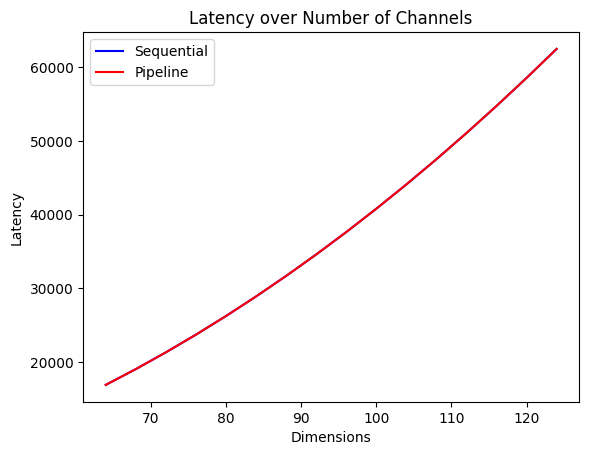

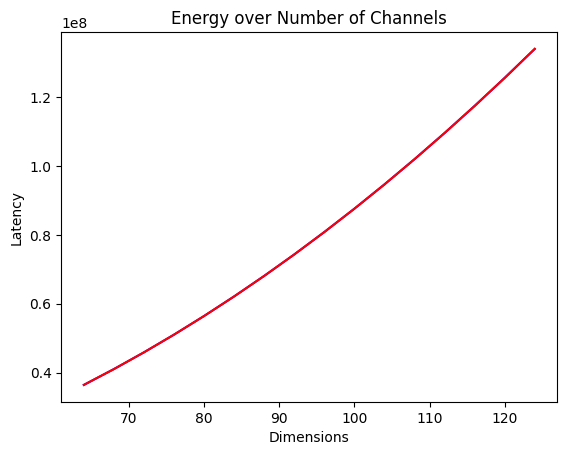

In [151]:
fig, latency_plot = plt.subplots()

#for latency
# Plot the first y array
latency_plot.plot(x_array_dimensions, y_latency_array_sequential, 'b-', label='Sequential')
latency_plot.plot(x_array_dimensions, y_latency_array_pipeline, 'r-', label='Pipeline')

latency_plot.set_xlabel('Dimensions')
latency_plot.set_ylabel('Latency')
latency_plot.set_title('Latency over Number of Channels')

# Show legend and grid
latency_plot.legend()
# ax1.grid(True)

# Show the plot
plt.show()

#######
# ENERGY
#######
fig, energy_plot = plt.subplots()

#for latency
# Plot the first y array
energy_plot.plot(x_array_dimensions, y_energy_array_sequential, 'b-', label='Sequential')
energy_plot.plot(x_array_dimensions, y_energy_array_pipeline, 'r-', label='Pipeline')

energy_plot.set_xlabel('Dimensions')
energy_plot.set_ylabel('Latency')
energy_plot.set_title('Energy over Number of Channels')

# Show legend and grid
latency_plot.legend()
# ax1.grid(True)

# Show the plot
plt.show()


From the convolution and matrix multiplication results, we can see that, for the former, pipeline fusion has significant energy and latency savings, while for the latter, there is no difference because of a lack of opportunity for steps that can occur in a pipelined process for matrix multiplications.

# Hardware Optimization

The second part of our project involved tweaking hardware paramters to find the optimal architectures for pipeline and sequential mappings

## Sweep over PE

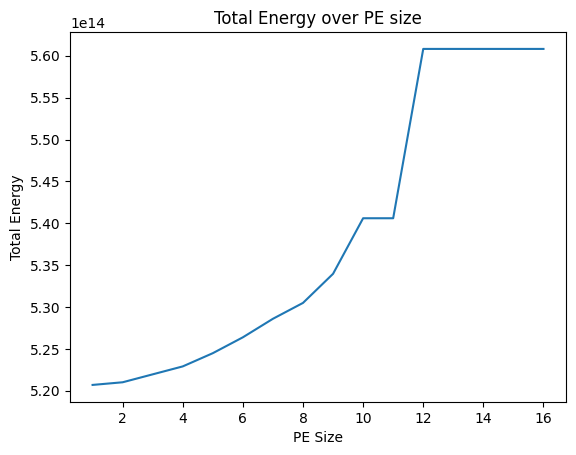

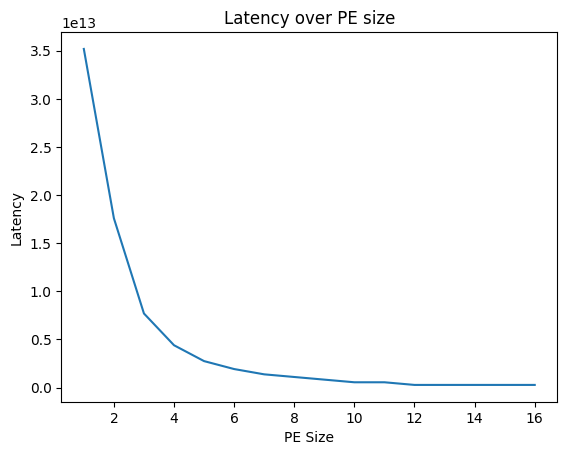

In [122]:
### CONV (sequential)
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

#yaml configs

class Component(dict): pass
class Container(dict): pass

# --- YAML Constructors (load from file) ---
def component_constructor(loader, node):
    return Component(loader.construct_mapping(node))

def container_constructor(loader, node):
    return Container(loader.construct_mapping(node))

# --- YAML Representers (dump to file) ---
def component_representer(dumper, data):
    return dumper.represent_mapping('!Component', data)

def container_representer(dumper, data):
    return dumper.represent_mapping('!Container', data)

def quoted_str_presenter(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:str', data, style='"')

yaml.add_representer(str, quoted_str_presenter)

# Register constructors
yaml.add_constructor('!Component', component_constructor, Loader=yaml.FullLoader)
yaml.add_constructor('!Container', container_constructor, Loader=yaml.FullLoader)

# Register representers
yaml.add_representer(Component, component_representer)
yaml.add_representer(Container, container_representer)


architecture_file = None
conv_mapping_file = None

# --- Load YAML ---
with open('../configs/architecture.yaml', 'r') as file:
    architecture_file = yaml.load(file, Loader=yaml.FullLoader)

with open('../configs/conv_mapping_sequential.yaml', 'r') as file:
    conv_mapping_file = yaml.load(file, Loader=yaml.FullLoader)

# # get the parts of dictionary that define whether we are doing pipelined
# # and tile_shape of each rank
for key in conv_mapping_file["mapping"]["nodes"]:
    if key['type'] == 'pipeline' or key['type'] == 'sequential':
        model = key
        pipelined = key['type']
        branches = key['branches']
        break

# print(f"{branches[1][1]=}, {branches[3][0]=}")
# # for key in branches:
#     # print(key)

# # print(model)
# print(f"{branches=}")
# # get PE from dictionary
for key in architecture_file["architecture"]["nodes"]:
    if key['name'] == 'PE':
        PE = key
        break
# # print(PE)

# # pipelined = True

# # model['type'] = 'pipeline' if pipelined else 'sequential'

# # C2 = conv_mapping_file["mapping"]["nodes"][1]['tile_shape'], can be whatever?
# # C = branches[0][1], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2 
# # M2 branches[1][0], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2

# # print(conv_mapping_file["mapping"]["nodes"][1]['tile_shape'])
# # print(branches[1][0])
# print(f"{branches=}")
# print(f"{branches[0][2]=}")
# print(f"{branches[1][1]=}")

x_array_pes = []
y_latency_array_sequential = []
y_energy_array_sequential = []

numNNEngines = 4
final_string = "PE_SIZE, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"
for i in range(1, 17):
    x_array_pes.append(i)
    numPEs = i
    PE['spatial']['meshX'] = numPEs
    PE['spatial']['meshY'] = numPEs
    PE['attributes']['meshX'] = numPEs
    PE['attributes']['meshY'] = numPEs
    
    c2_tile_shape= 32
    c_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ numPEs**2)
    m2_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ numPEs**2)
    # print(c_tile_shape, m2_tile_shape)
    
    conv_mapping_file["mapping"]["nodes"][1]['tile_shape'] = c2_tile_shape
    branches[0][2]['tile_shape'] = c_tile_shape
    branches[1][0]['tile_shape'] = m2_tile_shape
    # print(conv_mapping_file)
    
    with open('../configs/architecture.yaml', 'w') as file:
        yaml.dump(architecture_file, file, default_flow_style=False)
    
    with open('../configs/conv_mapping_sequential.yaml', 'w') as file:
        yaml.dump(conv_mapping_file, file, default_flow_style=False)
    
    
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping_sequential.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{numPEs},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{en[('output_reg', 'read')]},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    total_energy = sum(en[key] for key in en)
    y_energy_array_sequential.append(total_energy)
    y_latency_array_sequential.append(stats.latency)
# replace {0} with {en[('IntermediateBuffer', 'read')]} if bringing back intbuffer
# same for intbuffer write
plt.plot(x_array_pes, y_energy_array_sequential)
plt.xlabel("PE Size")
plt.ylabel("Total Energy")
plt.title("Total Energy over PE size")
plt.show()

plt.plot(x_array_pes, y_latency_array_sequential)
plt.xlabel("PE Size")
plt.ylabel("Latency")
plt.title("Latency over PE size")
plt.show()

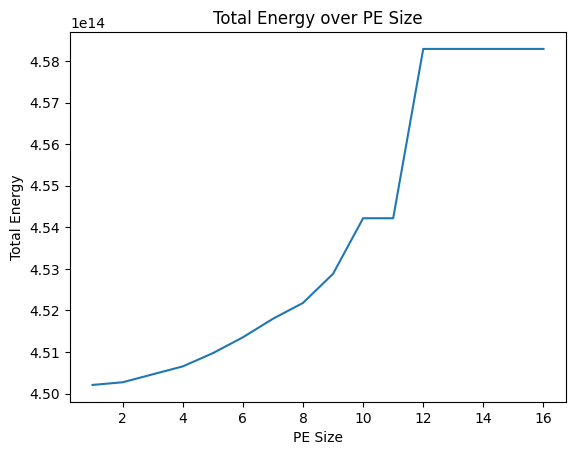

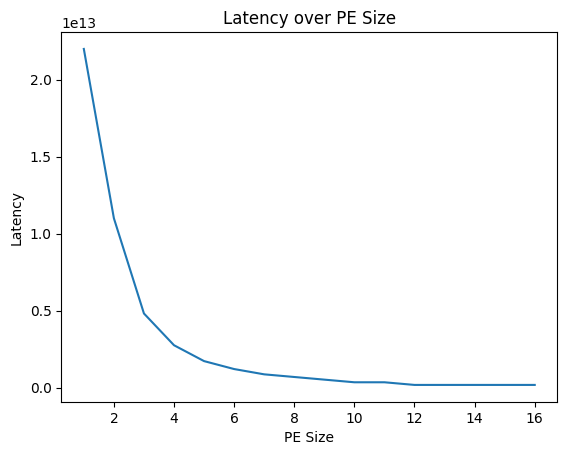

In [124]:
### with CONV files (pipeline)
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'PE'
}

#yaml configs

class Component(dict): pass
class Container(dict): pass

# --- YAML Constructors (load from file) ---
def component_constructor(loader, node):
    return Component(loader.construct_mapping(node))

def container_constructor(loader, node):
    return Container(loader.construct_mapping(node))

# --- YAML Representers (dump to file) ---
def component_representer(dumper, data):
    return dumper.represent_mapping('!Component', data)

def container_representer(dumper, data):
    return dumper.represent_mapping('!Container', data)

def quoted_str_presenter(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:str', data, style='"')

yaml.add_representer(str, quoted_str_presenter)

# Register constructors
yaml.add_constructor('!Component', component_constructor, Loader=yaml.FullLoader)
yaml.add_constructor('!Container', container_constructor, Loader=yaml.FullLoader)

# Register representers
yaml.add_representer(Component, component_representer)
yaml.add_representer(Container, container_representer)


architecture_file = None
conv_mapping_file = None

# --- Load YAML ---
with open('../configs/architecture.yaml', 'r') as file:
    architecture_file = yaml.load(file, Loader=yaml.FullLoader)

with open('../configs/conv_mapping.yaml', 'r') as file:
    conv_mapping_file = yaml.load(file, Loader=yaml.FullLoader)

# get the parts of dictionary that define whether we are doing pipelined
# and tile_shape of each rank
for key in conv_mapping_file["mapping"]["nodes"]:
    if key['type'] == 'pipeline' or key['type'] == 'sequential':
        model = key
        pipelined = key['type']
        branches = key['branches']
        break
# print(model)
# print(branches[1][0])
# get PE from dictionary
for key in architecture_file["architecture"]["nodes"]:
    if key['name'] == 'PE':
        PE = key
        break
# print(PE)

# pipelined = True

# model['type'] = 'pipeline' if pipelined else 'sequential'

# C2 = conv_mapping_file["mapping"]["nodes"][1]['tile_shape'], can be whatever?
# C = branches[0][1], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2 
# M2 branches[1][0], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2

# print(conv_mapping_file["mapping"]["nodes"][1]['tile_shape'])
# print(branches[1][0])

numNNEngines = 4

x_array_pes = []
y_energy_array_pipeline = []
y_latency_array_pipeline = []

final_string = "PE_SIZE, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"
for i in range(1, 17):
    x_array_pes.append(i)
    numPEs = i
    PE['spatial']['meshX'] = numPEs
    PE['spatial']['meshY'] = numPEs
    # PE['attributes']['meshX'] = numPEs
    # PE['attributes']['meshY'] = numPEs
    
    c2_tile_shape= 32
    c_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ numPEs**2)
    m2_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ numPEs**2)
    # print(c_tile_shape, m2_tile_shape)
    
    conv_mapping_file["mapping"]["nodes"][1]['tile_shape'] = c2_tile_shape
    branches[0][1]['tile_shape'] = c_tile_shape
    branches[1][0]['tile_shape'] = m2_tile_shape
    # print(conv_mapping_file)
    
    with open('../configs/architecture.yaml', 'w') as file:
        yaml.dump(architecture_file, file, default_flow_style=False)
    
    with open('../configs/conv_mapping.yaml', 'w') as file:
        yaml.dump(conv_mapping_file, file, default_flow_style=False)
    
    
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{numPEs},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{en[('output_reg', 'read')]},\
{en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
{en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    energy_sum = sum(en[key] for key in en)
    y_energy_array_pipeline.append(energy_sum)
    y_latency_array_pipeline.append(stats.latency)

plt.plot(x_array_pes, y_energy_array_pipeline)
plt.xlabel("PE Size")
plt.ylabel("Total Energy")
plt.title("Total Energy over PE Size")
plt.show()

plt.plot(x_array_pes, y_latency_array_pipeline)
plt.xlabel("PE Size")
plt.ylabel("Latency")
plt.title("Latency over PE Size")
plt.show()

# string_data = "Name,Age,City\nJohn,30,New York\nAlice,25,London\nBob,35,Paris"

# with open('peTestPipelineConv.csv', 'w', newline='\n') as csvfile:
#     writer = csv.writer(csvfile)
#     for row in final_string.splitlines():
#         writer.writerow(row.split(','))

# print(final_string)

Both sequential and pipeline fusion seem to need no more than a 12x12 PE array for their best performance in terms of latency, but this comes at the cost of considerably increasing energy requirements.

## Sweep over NNEngines

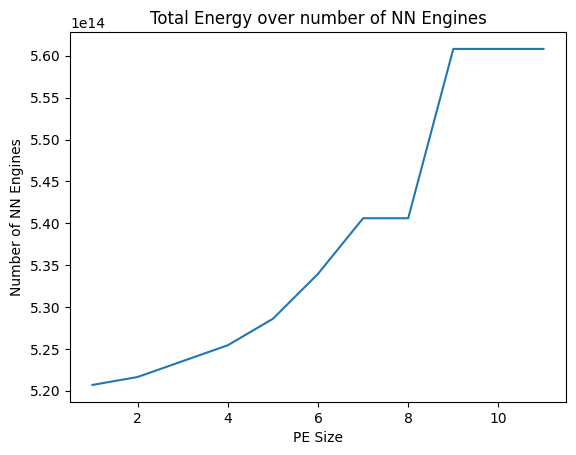

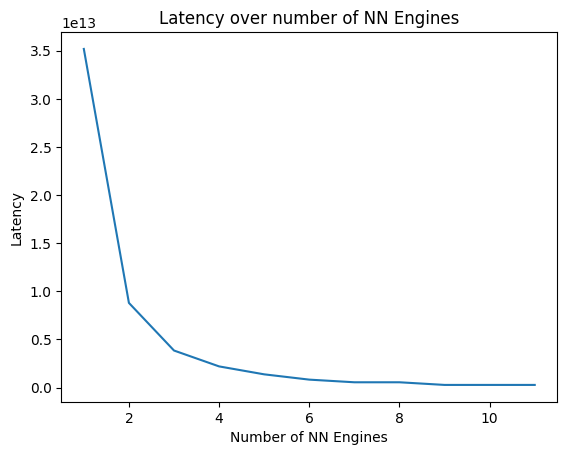

In [126]:
### with CONV files, but for NNEngines (sequential)
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'LocalBuffer',
    # 7: 'PE'
}

#yaml configs

class Component(dict): pass
class Container(dict): pass

# --- YAML Constructors (load from file) ---
def component_constructor(loader, node):
    return Component(loader.construct_mapping(node))

def container_constructor(loader, node):
    return Container(loader.construct_mapping(node))

# --- YAML Representers (dump to file) ---
def component_representer(dumper, data):
    return dumper.represent_mapping('!Component', data)

def container_representer(dumper, data):
    return dumper.represent_mapping('!Container', data)

def quoted_str_presenter(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:str', data, style='"')

yaml.add_representer(str, quoted_str_presenter)

# Register constructors
yaml.add_constructor('!Component', component_constructor, Loader=yaml.FullLoader)
yaml.add_constructor('!Container', container_constructor, Loader=yaml.FullLoader)

# Register representers
yaml.add_representer(Component, component_representer)
yaml.add_representer(Container, container_representer)


architecture_file = None
conv_mapping_file = None

# --- Load YAML ---
with open('../configs/architecture.yaml', 'r') as file:
    architecture_file = yaml.load(file, Loader=yaml.FullLoader)

with open('../configs/conv_mapping_sequential.yaml', 'r') as file:
    conv_mapping_file = yaml.load(file, Loader=yaml.FullLoader)

# # get the parts of dictionary that define whether we are doing pipelined
# # and tile_shape of each rank
for key in conv_mapping_file["mapping"]["nodes"]:
    if key['type'] == 'pipeline' or key['type'] == 'sequential':
        model = key
        pipelined = key['type'] == 'pipeline'
        branches = key['branches']
        break

# print(f"{branches[1][1]=}, {branches[3][0]=}")
# # for key in branches:
#     # print(key)

# # print(model)
# print(f"{branches=}")
# # get PE from dictionary
# for key in architecture_file["architecture"]["nodes"]:
#     if key['name'] == 'PE':
#         PE = key
#         break

for key in architecture_file["architecture"]["nodes"]:
    if key['name'] == 'nnEngine':
        nnEngine = key
        break
# print(f"{nnEngine=}")


# # print(PE)

# # pipelined = True

# # model['type'] = 'pipeline' if pipelined else 'sequential'

# # C2 = conv_mapping_file["mapping"]["nodes"][1]['tile_shape'], can be whatever?
# # C = branches[0][1], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2 
# # M2 branches[1][0], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2

# # print(conv_mapping_file["mapping"]["nodes"][1]['tile_shape'])
# # print(branches[1][0])
# print(f"{branches=}")
# print(f"{branches[0][2]=}")
# print(f"{branches[1][1]=}")

# final_string = "nnEngine_Size, latency, input_r, weights_r, output_r, dram_r, intbuffer_r, input_w, weights_w, output_w, dram_w, intbuffer_w, output_compute\n"
x_array_nn = []
y_energy_array_sequential = []
y_latency_array_sequential = []
for i in range(1, 12):
    x_array_nn.append(i)
    # print(f"{i=}")
    nnEngine['spatial']['meshX'] = i
    nnEngine['spatial']['meshY'] = i
    nnEngine['attributes']['meshX'] = i
    nnEngine['attributes']['meshY'] = i
    
    c2_tile_shape= 32
    c_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ i**2)
    m2_tile_shape = tile_shape = int(128/ (0.5 * numPEs**2) if pipelined else 128/ i**2)
    # print(c_tile_shape, m2_tile_shape)
    
    conv_mapping_file["mapping"]["nodes"][1]['tile_shape'] = c2_tile_shape
    branches[0][2]['tile_shape'] = c_tile_shape
    branches[1][0]['tile_shape'] = m2_tile_shape
    # print(conv_mapping_file)
    
    with open('../configs/architecture.yaml', 'w') as file:
        yaml.dump(architecture_file, file, default_flow_style=False)
    
    with open('../configs/conv_mapping_sequential.yaml', 'w') as file:
        yaml.dump(conv_mapping_file, file, default_flow_style=False)
    
    
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping_sequential.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    total_energy = sum(en[key] for key in en)
    y_energy_array_sequential.append(total_energy)
    y_latency_array_sequential.append(stats.latency)

plt.plot(x_array_nn, y_energy_array_sequential)
plt.xlabel("Number of NN Engines")
plt.ylabel("Total Energy")
plt.title("Total Energy over number of NN Engines")
plt.show()

plt.plot(x_array_nn, y_latency_array_sequential)
plt.xlabel("Number of NN Engines")
plt.ylabel("Latency")
plt.title("Latency over number of NN Engines")
plt.show()

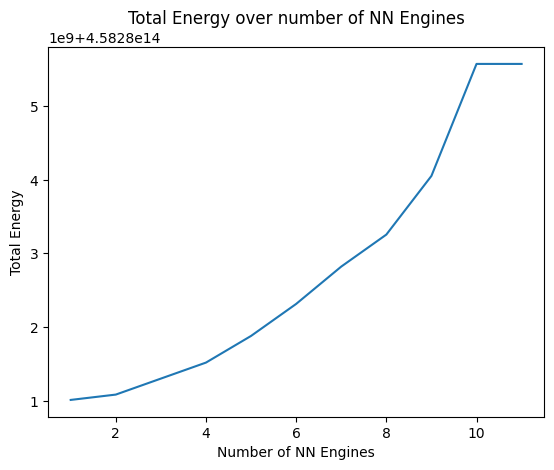

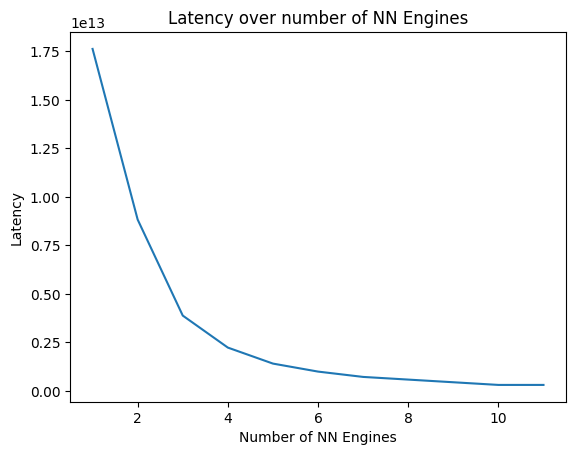

In [128]:
### with CONV files, but for NNEngines (pipeline)
from util import *
from pprint import pp
from pytimeloop.looptree.run import run_looptree
import yaml

# As previously mentioned, bindings map levels specified in the mapping
# to the hardware units specified in the architecture spec.
bindings = {
    0: 'MainMemory',
    1: 'IntermediateBuffer',
    # 2: 'LocalBuffer',
    # 3: 'input_reg',
    # 4: 'weight_reg',
    # 5: 'output_reg',
    3: 'MACC',
    4: 'input_reg',
    5: 'weights_reg',
    6: 'output_reg',
    # 7: 'LocalBuffer',
    # 7: 'PE'
}

#yaml configs

class Component(dict): pass
class Container(dict): pass

# --- YAML Constructors (load from file) ---
def component_constructor(loader, node):
    return Component(loader.construct_mapping(node))

def container_constructor(loader, node):
    return Container(loader.construct_mapping(node))

# --- YAML Representers (dump to file) ---
def component_representer(dumper, data):
    return dumper.represent_mapping('!Component', data)

def container_representer(dumper, data):
    return dumper.represent_mapping('!Container', data)

def quoted_str_presenter(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:str', data, style='"')

yaml.add_representer(str, quoted_str_presenter)

# Register constructors
yaml.add_constructor('!Component', component_constructor, Loader=yaml.FullLoader)
yaml.add_constructor('!Container', container_constructor, Loader=yaml.FullLoader)

# Register representers
yaml.add_representer(Component, component_representer)
yaml.add_representer(Container, container_representer)


architecture_file = None
conv_mapping_file = None

# --- Load YAML ---
with open('../configs/architecture.yaml', 'r') as file:
    architecture_file = yaml.load(file, Loader=yaml.FullLoader)

with open('../configs/conv_mapping.yaml', 'r') as file:
    conv_mapping_file = yaml.load(file, Loader=yaml.FullLoader)

# # get the parts of dictionary that define whether we are doing pipelined
# # and tile_shape of each rank
for key in conv_mapping_file["mapping"]["nodes"]:
    if key['type'] == 'pipeline' or key['type'] == 'sequential':
        model = key
        pipelined = key['type'] == 'pipeline'
        branches = key['branches']
        break

# print(f"{branches[1][1]=}, {branches[3][0]=}")
# # for key in branches:
#     # print(key)

# # print(model)
# print(f"{branches=}")
# # get PE from dictionary
# for key in architecture_file["architecture"]["nodes"]:
#     if key['name'] == 'PE':
#         PE = key
#         break

for key in architecture_file["architecture"]["nodes"]:
    if key['name'] == 'nnEngine':
        nnEngine = key
        break
# print(f"{nnEngine=}")


# # print(PE)

# # pipelined = True

# # model['type'] = 'pipeline' if pipelined else 'sequential'

# # C2 = conv_mapping_file["mapping"]["nodes"][1]['tile_shape'], can be whatever?
# # C = branches[0][1], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2 
# # M2 branches[1][0], pipelined ? tile_shape = 128/ (0.5 * PE_SIZE**2) : 128/ PE_SIZE**2

# # print(conv_mapping_file["mapping"]["nodes"][1]['tile_shape'])
# # print(branches[1][0])
# print(f"{branches=}")
# print(f"{branches[0][2]=}")
# print(f"{branches[1][1]=}")

x_array_nn = []
y_energy_array_pipeline = []
y_latency_array_pipeline = []
for i in range(1, 12):
    x_array_nn.append(i)
    nnEngine['spatial']['meshX'] = i
    nnEngine['spatial']['meshY'] = i
    nnEngine['attributes']['meshX'] = i
    nnEngine['attributes']['meshY'] = i
    
    c2_tile_shape= 32
    c_tile_shape = tile_shape = int(128/ (0.5 * i**2) if pipelined else 128/ i**2)
    m2_tile_shape = tile_shape = int(128/ (0.5 * i**2) if pipelined else 128/ i**2)
    # print(c_tile_shape, m2_tile_shape)
    
    conv_mapping_file["mapping"]["nodes"][1]['tile_shape'] = c2_tile_shape
    branches[0][2]['tile_shape'] = c_tile_shape
    branches[1][0]['tile_shape'] = m2_tile_shape
    # print(conv_mapping_file)
    
    with open('../configs/architecture.yaml', 'w') as file:
        yaml.dump(architecture_file, file, default_flow_style=False)
    
    with open('../configs/conv_mapping.yaml', 'w') as file:
        yaml.dump(conv_mapping_file, file, default_flow_style=False)
    
    
    stats = run_looptree(
        CONFIG_DIR,
        # ['architecture.yaml', 'two_fc.workload.yaml', 'layer-by-layer.mapping.yaml'],
        ['architecture.yaml', 'conv_workload.yaml','conv_mapping.yaml'],
        TMP_DIR,
        bindings,
        call_accelergy=True
    )
    en = stats.energy
    final_string += f"{i},{stats.latency/1e9},{en[('input_reg', 'read')]},{en[('weights_reg', 'read')]},{en[('output_reg', 'read')]},\
    {en[('MainMemory', 'read')]},{en[('IntermediateBuffer', 'read')]},{en[('input_reg', 'write')]},{en[('weights_reg', 'write')]},{en[('output_reg', 'write')]},\
    {en[('MainMemory', 'write')]},{en[('IntermediateBuffer', 'write')]},{en[('output_reg', 'compute')]}\n"
    total_energy = sum(en[key] for key in en)
    y_energy_array_pipeline.append(total_energy)
    y_latency_array_pipeline.append(stats.latency)

plt.plot(x_array_nn, y_energy_array_pipeline)
plt.xlabel("Number of NN Engines")
plt.ylabel("Total Energy")
plt.title("Total Energy over number of NN Engines")
plt.show()

plt.plot(x_array_nn, y_latency_array_pipeline)
plt.xlabel("Number of NN Engines")
plt.ylabel("Latency")
plt.title("Latency over number of NN Engines")
plt.show()


Both types of fusion flatten out after about 6x6